In [1]:
#alpha = 0.5, gamma = 0.0001

In [2]:
import numpy as np
import torch
from data.synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
random.seed(0)

# parameters
batch_size = 100
N = 500
N_input = 20
N_output = 20  
sigma = 0.01
gamma = 0.0001

# Load synthetic dataset
X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

# training losses over all the epochs
tr_loss = []
tr_loss_shape = []
tr_loss_temp = []

def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        
        l, l_shape, l_temp, n_tr_steps = 0, 0, 0, 0

        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
            
            if (loss_type=='dilate_shape'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
            
            # adding training losses
            l += loss.item() 
            l_shape += loss_shape.item()
            l_temp += loss_temporal.item()
            n_tr_steps += 1
        tr_loss.append(l/float(n_tr_steps))
        tr_loss_shape.append(l_shape/float(n_tr_steps))
        tr_loss_temp.append(l_temp/float(n_tr_steps)) 
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

 
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 


encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

# encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
# decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
# net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
# train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

# encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
# decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
# net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
# train_model(net_gru_dilate,loss_type='dilate_shape',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)




epoch  0  loss  1.3438990116119385  loss shape  2.4379918575286865  loss temporal  0.2498062402009964
 Eval mse=  0.13580049872398375  dtw=  1.3405283244969965  tdi=  0.175835
epoch  50  loss  1.2486653327941895  loss shape  2.300229787826538  loss temporal  0.19710098206996918
 Eval mse=  0.10931022018194199  dtw=  1.2117988846270067  tdi=  0.28677500000000006
epoch  100  loss  1.0616328716278076  loss shape  2.0612165927886963  loss temporal  0.06204908341169357
 Eval mse=  0.0869439721107483  dtw=  1.0473288320426177  tdi=  0.144345
epoch  150  loss  0.821044921875  loss shape  1.279458999633789  loss temporal  0.36263078451156616
 Eval mse=  0.06090432032942772  dtw=  0.8982067273413985  tdi=  0.40383499999999994
epoch  200  loss  1.390718936920166  loss shape  2.557050943374634  loss temporal  0.22438684105873108
 Eval mse=  0.12565133571624756  dtw=  1.2654058101661505  tdi=  0.60765
epoch  250  loss  1.1520791053771973  loss shape  1.573399305343628  loss temporal  0.73075896501

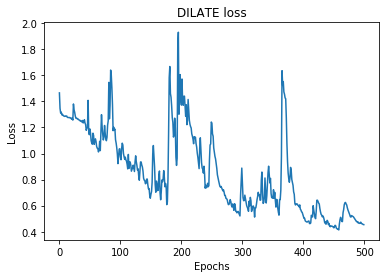

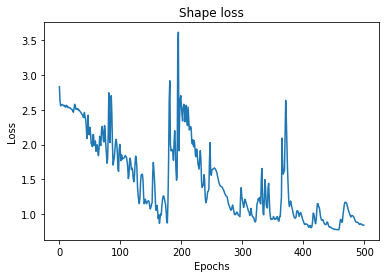

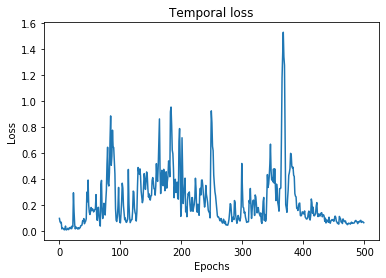

In [6]:
# plot training losses - 
plt.figure()
plt.plot(tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DILATE loss')

plt.show()
plt.figure()
plt.plot(tr_loss_shape)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Shape loss')
plt.show()
plt.figure()
plt.plot(tr_loss_temp)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Temporal loss')
plt.show()



